In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

University of Toronto CIFAR-10 Dataset

60000 Images 3 channels. 10 classes

In [2]:
import torchvision
import torchvision.transforms as transform

In [3]:
trainsets = torchvision.datasets.CIFAR10(root = './data',train = True,download = True,transform = transform.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
classes = ('Airplane','Automobile','bird','cat','deer','dog','frog', 'horse','ship','truck')

In [5]:
trainloader = torch.utils.data.DataLoader(trainsets,batch_size=4,shuffle = True) # Everytime I get a shuffled 4 Images

In [6]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images.shape)
print(images[0].shape)

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])


#Lets Visualize the Image


In [7]:
img = images[0]

In [8]:
npimg = img.numpy()

In [9]:
npimg.shape

(3, 32, 32)

In [10]:
npimg = np.transpose(npimg,(1,2,0))

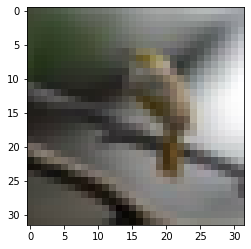

In [11]:
plt.figure()
plt.imshow(npimg)

In [12]:
def imshow(images):
  npimg1 = images.numpy()
  img = np.transpose(npimg1,(1,2,0))
  plt.imshow(img)
  plt.show()

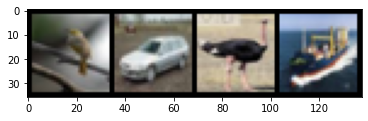

bird Automobile bird ship


In [13]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

# Convolution


In [14]:
import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv = nn.Conv2d(3,16,3,padding = (1,1),stride = (1,1)) #depth = channels , #No. of kernels = K, # F- spatial Extent of the kernel 
  def forward(self,X):
    return self.conv(X)

In [15]:
firstnet = CNN()

In [16]:
out = firstnet(images)
out.shape #Since we didn't use Padding the image dimensions have shrunk

torch.Size([4, 16, 32, 32])

In [17]:
for param in firstnet.parameters():
  print(param.shape) #16 kernels 3channels 3X3 spatial filter
  #16 Bias terms

torch.Size([16, 3, 3, 3])
torch.Size([16])


In [18]:
out1 = out[0,0,:,:].detach().numpy()
out1.shape

(32, 32)

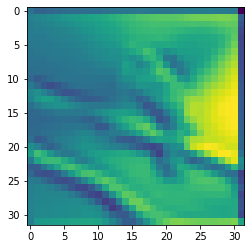

In [19]:
plt.imshow(out1)
plt.show() #preprocessed feature of the bird we are seeing

#DeepCNN

In [20]:
class deepCNN(nn.Module):
  def __init__(self):
    super(deepCNN, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,8,3),  #input (4-batch size,3,32,32) -> #3 Channels, 8 No. of Kernels, 3 F Spatial Extent -> (4,8,30,30)
        nn.Conv2d(8,16,3) #8 Channels, 16 No. of Kernels, 3 F Spatial Extent - > (4,16,28,28)
    )
  def forward(self,X):
    return self.model(X)

In [21]:
Deepcnn = deepCNN()

In [22]:
out = Deepcnn.forward(images)
out.shape

torch.Size([4, 16, 28, 28])

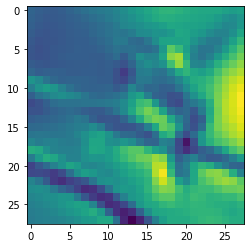

In [23]:
npout = out[0,0,:,:].detach().numpy()
plt.imshow(npout)
plt.show()

In [24]:
class deepCNN_v2(nn.Module):
  def __init__(self):
    super(deepCNN_v2,self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,6,5), #output -> (4,6,28,28)
        nn.AvgPool2d(2,stride = 2), #2X2 patch size and stride = 2,2 - >  (4,6,14,14)
        nn.Conv2d(6,16,5), # (4,16,10,10)
        nn.AvgPool2d(2,stride = 2) #(4,16,5,5)
    )
  def forward(self,X):
    return self.model(X)

In [25]:
deepcnn = deepCNN_v2()

In [26]:
out = deepcnn.forward(images)
print(out.shape)
npout = out[0,0,:,:].detach().numpy()

torch.Size([4, 16, 5, 5])


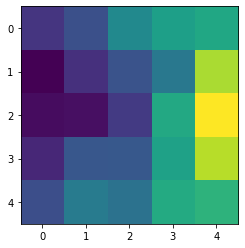

In [27]:
plt.imshow(npout)
plt.show()

#Lenet Architecture

<img src ='https://classic.d2l.ai/_images/lenet.svg'> </img>

In [70]:
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet,self).__init__()
    self.convol = nn.Sequential(
        nn.Conv2d(3,6,5), #(4,3,32,32) -> (4,6,28,28)
        nn.LeakyReLU(),
        nn.AvgPool2d(2,stride=2), #(4,6,14,14)
        nn.Conv2d(6,16,5),# (4,16,10,10)
        nn.LeakyReLU(),
        nn.AvgPool2d(2,stride = 2) #(4,16,5,5)
        #after this we need to flatten the structure into a 1d vector    16*5*5 = 400     
    )
    self.FCNN = nn.Sequential(
        nn.Linear(400,120),
        nn.LeakyReLU(),
        nn.Linear(120,84),
        nn.LeakyReLU(),
        nn.Linear(84,10) #Softmax will be available in training
    )
  def forward(self,X):
    # print("The shape right now is:",X.shape)
    X = self.convol(X)
    # print("The shape right now is:",X.shape)
    X = X.view(X.shape[0],-1)
    # print("The shape right now is:",X.shape) #Flattening to N,400
    X = self.FCNN(X)
    # print("The shape right now is:",X.shape)
    return X


In [29]:
lenet = Lenet()

In [30]:
out = lenet.forward(images)

The shape right now is: torch.Size([4, 3, 32, 32])
The shape right now is: torch.Size([4, 16, 5, 5])
The shape right now is: torch.Size([4, 400])
The shape right now is: torch.Size([4, 10])


In [31]:
max_vals,class_pred =torch.max(out.data,1) # 1 corresponds to column

In [32]:
class_pred

tensor([1, 1, 1, 1])

#LeNet Training

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [72]:
import torch.optim as optim

In [73]:
batch_size = 128
train = torchvision.datasets.CIFAR10(root='./data',train = True, download = True,transform = transform.ToTensor())
trainset = torch.utils.data.DataLoader(train,batch_size=batch_size, shuffle = True)
test = torchvision.datasets.CIFAR10(root='./data',train = False, download = True,transform = transform.ToTensor())
testset = torch.utils.data.DataLoader(test,batch_size=batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [74]:
def accuracy(dataloader,model):
  total, correct = 0,0
  for data in dataloader:
    input,labels= data
    input,labels = input.to(device),labels.to(device)
    output = model(input)
    max_Val,pred_class = torch.max(output.data,1)
    total += labels.size(0)
    correct += (pred_class == labels).sum()
  return torch.true_divide(correct*100,total) 

In [75]:
lenet = Lenet().to(device)
lossfn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

In [76]:
%%time
max_epoch = 32
for epoch in range(max_epoch):
  for i,data in enumerate(trainset,0):
    inps, labels = data
    inps, labels = inps.to(device),labels.to(device)
    opt.zero_grad()
    loss = lossfn(lenet(inps),labels)
    loss.backward()
    opt.step()
  print('Epoch :',epoch,'/',max_epoch,'Loss is:',loss.item())

Epoch : 0 / 32 Loss is: 1.538364052772522
Epoch : 1 / 32 Loss is: 1.7239067554473877
Epoch : 2 / 32 Loss is: 1.23875892162323
Epoch : 3 / 32 Loss is: 1.424127459526062
Epoch : 4 / 32 Loss is: 1.251449704170227
Epoch : 5 / 32 Loss is: 1.192341923713684
Epoch : 6 / 32 Loss is: 1.157594919204712
Epoch : 7 / 32 Loss is: 1.2191708087921143
Epoch : 8 / 32 Loss is: 1.1265733242034912
Epoch : 9 / 32 Loss is: 1.522506833076477
Epoch : 10 / 32 Loss is: 1.0725568532943726
Epoch : 11 / 32 Loss is: 1.0506104230880737
Epoch : 12 / 32 Loss is: 0.9163331985473633
Epoch : 13 / 32 Loss is: 0.8944609761238098
Epoch : 14 / 32 Loss is: 1.1217654943466187
Epoch : 15 / 32 Loss is: 0.8239011764526367
Epoch : 16 / 32 Loss is: 0.8525492548942566
Epoch : 17 / 32 Loss is: 0.9200846552848816
Epoch : 18 / 32 Loss is: 0.7832186818122864
Epoch : 19 / 32 Loss is: 0.8203381299972534
Epoch : 20 / 32 Loss is: 0.777091920375824
Epoch : 21 / 32 Loss is: 0.804993748664856
Epoch : 22 / 32 Loss is: 0.5650824904441833
Epoch : 

In [77]:
%%time
print('Train Accuracy :{} Test Accuracy :{}'.format(accuracy(trainset,lenet),accuracy(testset,lenet)))

Train Accuracy :78.05599975585938 Test Accuracy :62.37999725341797
CPU times: user 5.31 s, sys: 26.8 ms, total: 5.33 s
Wall time: 5.33 s
